In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## EXTERNAL
import pandas as pd 
import numpy as np 
import pickle
import shutil
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import sklearn
import time
import os
import random 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

##INTERNAL
from models import Autoencoder
from models import Sequence
from models import waveletSmooth

from utils import prepare_data_lstm, ExampleDataset, save_checkpoint, evaluate_lstm, backtest


# Caricamento dei dati

In [3]:
path = "./data/S&P500IndexData-Table1.csv"
data_master = pd.read_csv(path, sep=";")
data_master["Date"] = pd.to_datetime(data_master["Ntime"].astype(str))
data_master.drop("time", inplace=True, axis=1)
data_master.drop("Ntime", inplace=True, axis=1)
data_master.set_index("Date", inplace=True)
pd.set_option('display.max_columns', None)
data_master

,Close Price,Open Price,High Price,Low Price,Volume,MACD,CCI,ATR,BOLL,EMA20,MA10,MTM6,MA5,MTM12,ROC,SMI,WVAD,US Dollar Index,Federal Fund Rate
Date,,,,,,,,,,,,,,,,,,,
2008-07-01,1284.91,1276.69,1285.31,1260.68,584629.0,-25.545595,-127.422348,24.63,1347.154231,1327.453482,1307.927,-33.09,1289.682,-75.12,-5.523408,-0.039542,-3.772245e+07,72.3400,2.11
2008-07-02,1261.52,1285.82,1292.17,1261.51,527609.0,-27.571986,-115.864929,30.66,1342.391538,1321.174102,1300.298,-52.77,1277.592,-98.62,-7.250724,-0.060551,-5.204278e+07,71.9900,1.95
2008-07-03,1262.90,1262.96,1271.48,1252.01,324759.0,-28.735319,-115.171527,19.47,1337.470769,1315.624188,1292.305,-59.07,1273.542,-88.03,-6.516252,-0.041755,-5.556148e+07,72.7300,1.92
2008-07-07,1252.31,1262.90,1273.95,1240.68,526542.0,-30.164080,-111.302302,33.27,1331.857308,1309.594265,1285.743,-26.07,1268.328,-85.50,-6.740987,-0.049841,-5.352552e+07,72.7100,1.99
2008-07-08,1273.70,1251.84,1274.17,1242.84,603411.0,-29.233405,-82.732708,31.33,1326.985000,1306.175764,1281.313,-6.30,1267.068,-69.13,-3.356020,-0.030884,-3.909113e+07,72.9600,1.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-26,2146.10,2158.54,2158.54,2145.04,357811.0,-3.864936,-10.284991,19.65,2163.793077,2157.914061,2146.918,20.33,2158.170,-35.20,-1.846804,0.008891,-1.701630e+07,95.2986,0.40
2016-09-27,2159.93,2146.04,2161.13,2141.55,366113.0,-3.200729,22.969783,19.58,2162.872308,2158.106055,2150.209,20.81,2162.204,32.12,-1.199821,0.015815,-1.258582e+07,95.4499,0.40
2016-09-28,2171.37,2161.85,2172.40,2151.79,361908.0,-1.731270,100.879276,20.61,2162.438846,2159.369288,2154.769,31.61,2163.854,12.33,-0.455233,0.011104,-7.050632e+06,95.4275,0.40


# Denoising e normalizzazione dei dati

# Modelli

## LSTM

In [ ]:
#Build

# set ramdom seed to 0
np.random.seed(0)
torch.manual_seed(0)

n_features = x_train.size()[1]

# build the model
if n == 0:
    seq = Sequence(n_features,hidden_size=100, nb_layers=3)

# get the number of model parameters
print('Number of model parameters: {}'.format(
    sum([p.data.nelement() for p in seq.parameters()])))

# we use the mean squared error loss
criterion = nn.MSELoss()

optimizer = optim.Adam(params=seq.parameters(), lr=0.0005)

start_epoch = 0 
epochs = 100#5000

global_loss_val = np.inf
#begin to train
global_profit_val = -np.inf

In [ ]:
##Train
#TODO fai funzione
for i in range(start_epoch, epochs):
    seq.train()
    loss_train = 0

    # shuffle ONLY training set        
    combined = list(zip(x_train, y_train))
    random.shuffle(combined)
    x_train=[]
    y_train=[]
    x_train, y_train = zip(*combined)

    # initialize trainloader with newly shuffled training data        
    trainloader = ExampleDataset(x_train, y_train, batchsize)

    pred_train = []
    target_train = []
    for j in range(len(trainloader)):
        sample = trainloader[j]
        sample_x = sample["x"]

        if len(sample_x) != 0:

            sample_x = np.stack(sample_x)
            input = torch.FloatTensor(sample_x)
            target = torch.FloatTensor([x for x in sample["y"]])

            optimizer.zero_grad()
            out = seq(input)
            loss = criterion(out, target[-1,None])

            loss_train += float(loss.data.numpy())
            pred_train.extend(out.data.numpy().flatten().tolist())
            target_train.extend(target.data.numpy().flatten().tolist())

            loss.backward()

            optimizer.step()


    if i % 10 == 0:

        plt.plot(pred_train)
        plt.plot(target_train)
        plt.show()

        loss_val, pred_val, target_val = evaluate_lstm(dataloader=valloader, model=seq, criterion=criterion)

        plt.scatter(range(len(pred_val)), pred_val)
        plt.scatter(range(len(pred_val)), target_val)
        plt.show()

        index, real = backtest(pred_val, y_validate)

        print(index[-1])
        # save according to profitability
        if index[-1]>global_profit_val and i>200:
            print("CURRENT BEST")
            global_profit_val = index[-1]
            save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=True, filename='checkpoint_lstm.pth.tar')

        save_checkpoint({'epoch': i + 1, 'state_dict': seq.state_dict()}, is_best=False, filename='checkpoint_lstm.pth.tar')

        print("LOSS TRAIN: " + str(float(loss_train)))        
        print("LOSS VAL: " + str(float(loss_val)))
        print(i)

# do the final test
# first load the best checkpoint on the val set

resume = "./runs/checkpoint/model_best.pth.tar"
#resume = "./runs/HF/checkpoint_lstm.pth.tar"

if os.path.isfile(resume):
    print("=> loading checkpoint '{}'".format(resume))
    checkpoint = torch.load(resume)
    start_epoch = checkpoint['epoch']
    seq.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (epoch {})"
          .format(resume, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(resume))

seq.eval()

loss_test, preds_test, target_test = evaluate_lstm(dataloader=testloader, model=seq, criterion=criterion)

print("LOSS TEST: " + str(float(loss_test)))

temp2 = y_test.numpy().flatten().tolist()
y_test_lst.extend(temp2)

plt.plot(preds_test)
plt.plot(y_test_lst)
plt.scatter(range(len(preds_test)), preds_test)
plt.scatter(range(len(y_test_lst)), y_test_lst)
plt.savefig("test_preds.pdf")

## RNN

In [ ]:
# Build

In [ ]:
# Train

# Valutazione dei modello con validazione su diversi intevalli di tempo

## Trasformazioni

In [4]:
'''Scales the inputs such that they are in an appropriate range''' 
def get_scaled_features(feats_to_scale):
    feats = feats_to_scale.copy()
    feats["Close Price"].loc[:] = feats["Close Price"].loc[:]/1000
    feats["Open Price"].loc[:] = feats["Open Price"].loc[:]/1000
    feats["High Price"].loc[:] = feats["High Price"].loc[:]/1000
    feats["Low Price"].loc[:] = feats["Low Price"].loc[:]/1000
    feats["Volume"].loc[:] = feats["Volume"].loc[:]/1000000
    feats["MACD"].loc[:] = feats["MACD"].loc[:]/10
    feats["CCI"].loc[:] = feats["CCI"].loc[:]/100
    feats["ATR"].loc[:] = feats["ATR"].loc[:]/100
    feats["BOLL"].loc[:] = feats["BOLL"].loc[:]/1000
    feats["EMA20"].loc[:] = feats["EMA20"].loc[:]/1000
    feats["MA10"].loc[:] = feats["MA10"].loc[:]/1000
    feats["MTM6"].loc[:] = feats["MTM6"].loc[:]/100
    feats["MA5"].loc[:] = feats["MA5"].loc[:]/1000
    feats["MTM12"].loc[:] = feats["MTM12"].loc[:]/100
    feats["ROC"].loc[:] = feats["ROC"].loc[:]/10
    feats["SMI"].loc[:] = feats["SMI"].loc[:] * 10
    feats["WVAD"].loc[:] = feats["WVAD"].loc[:]/100000000
    feats["US Dollar Index"].loc[:] = feats["US Dollar Index"].loc[:]/100
    feats["Federal Fund Rate"].loc[:] = feats["Federal Fund Rate"].loc[:]
    return feats

In [5]:
def train_valid_test_split(data, step_size, out_type=np.float):
    return data[:-2*step_size].to_numpy(dtype=out_type, copy=True), data[-2*step_size:-step_size].to_numpy(dtype=out_type, copy=True) ,data[-step_size:].to_numpy(dtype=out_type, copy=True)

In [22]:
#TODO metti parametro look in the future(boolean)
def apply_wavelet_transform(data, consider_future=True):
    res = data.copy()
    if(len(res.shape) == 1):
        res = res[...,np.newaxis]
    if(consider_future):
        for i in range(res.shape[1]):
            res[:,i] = waveletSmooth(res[:,i].copy(), level=1)[-len(res):]
    else:
        for i in range(res.shape[1]):
            for j in range(res.shape[0]):
                if(j > 0):
                    res[j,i] = waveletSmooth(res[:j,i].copy(), level=1)[-1]
    return res

## Inizializzazione del'algoritmo di validazione

In [13]:
##init training loop TODO fai refactoring training loop
n=0

y_test_lst = []
preds = []
ct = 0

In [14]:
# roll by approx. 60 days - 3 months of trading days
step_size = int(0.1 * num_datapoints)
# calculate number of iterations we can do over the entire data set
num_iterations = int(np.ceil((len(data_master)-num_datapoints)/step_size))+2

## Creazione del dataset

In [15]:
##SCALE THE DATA
# consideriamo 600 giorni di trading che sono poco più di 2 anni
num_datapoints = 600
data = data_master.iloc[n*step_size:num_datapoints+n*step_size,:].copy()
data.columns = [col.strip() for col in data.columns.tolist()]
ct +=1
feats = get_scaled_features(data)

In [16]:
## CREATE AND SPLIT THE DATASET
X = feats.copy().drop("Close Price", axis=1)
Y = feats["Close Price"].copy()

X_train, X_valid, X_test = train_valid_test_split(X, step_size)
Y_train, Y_valid, Y_test = train_valid_test_split(Y, step_size)

In [24]:
## DENOISING USING DWT
#TODO validation denoise è da fare solo su giorni considerati in predizione(ad es 10)
#TODO vedi se con metodo originale risultati diversi, in caso vedi perche'(se effettivamente future data leaking)
#TODO capisci bene wavelet per mettere spiegazione in relazione e per fare TODO sopra(guarda anche codice e doc wavelet)
X_train_denoised = apply_wavelet_transform(X_train)
X_valid_denoised = apply_wavelet_transform(np.append(X_train, X_valid, axis=0))
X_test_denoised = apply_wavelet_transform(np.append(np.append(X_train, X_valid, axis=0), X_test, axis=0))
Y_train_denoised = apply_wavelet_transform(Y_train)
Y_valid_denoised = apply_wavelet_transform(np.append(Y_train, Y_valid, axis=0))
Y_test_denoised = apply_wavelet_transform(np.append(np.append(Y_train, Y_valid, axis=0), Y_test, axis=0))
train_denoised = np.concatenate((X_train, Y_train[...,None]), axis=1)
valid_denoised = np.concatenate((X_valid, Y_valid[...,None]), axis=1)
test_denoised = np.concatenate((X_test, Y_test[...,None]), axis=1)

## Create the Data Loaders

In [14]:
##Cerate the data Loaders
x_train = torch.from_numpy(X_train_denoised.astype(np.float32))
y_train = torch.from_numpy(Y_train_denoised.astype(np.float32))
x_validate = torch.from_numpy(X_valid_denoised.astype(np.float32))
y_validate = torch.from_numpy(Y_valid_denoised.astype(np.float32))
x_test = torch.from_numpy(X_test_denoised.astype(np.float32))
y_test = torch.from_numpy(Y_test_denoised.astype(np.float32))

batchsize = 4

trainloader = ExampleDataset(x_train, y_train, batchsize)
valloader = ExampleDataset(x_validate, y_validate, 1)
testloader = ExampleDataset(x_test, y_test, 1)

# Confronto predizioni modelli

In [97]:
n_days = 10
preds = []
for i in range(600):
    preds.append(seq(torch.from_numpy(X.to_numpy().astype(np.float32)[i:i+n_days]))[0])

In [100]:
Y_preds = pd.Series(preds, index=Y.index)

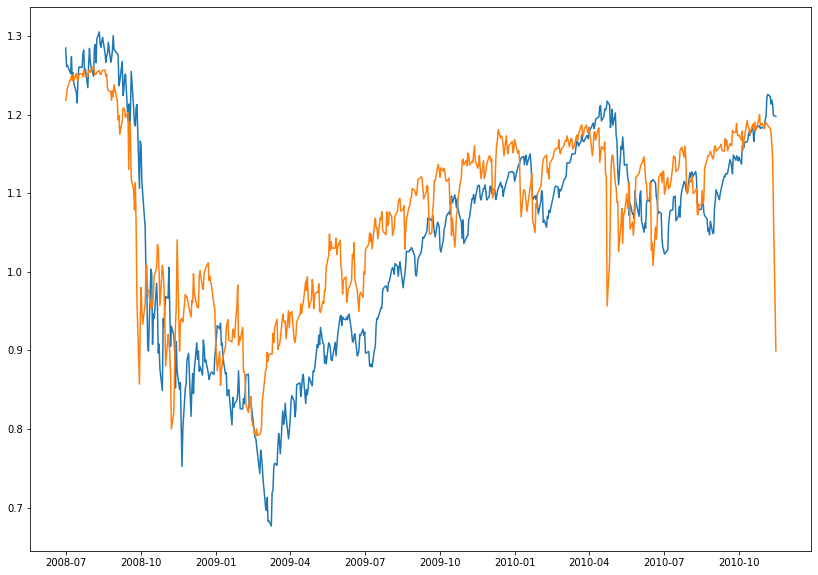

In [102]:
figure = plt.figure(figsize=(14, 10))
plt.plot(Y)
plt.plot(Y_preds)